In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import time
import pickle
import re 
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, 
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
%matplotlib inline

In [2]:
DATASET_COLUMNS  = ["sentiment", "ids", "date", "flag", "user", "text"]

dataset = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding="ISO-8859-1", names = DATASET_COLUMNS)

In [3]:
dataset.head()

sentiment         ids                          date      flag  \
0          0  1467810369  Mon Apr 06 22:19:45 PDT 2009  NO_QUERY   
1          0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
2          0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
3          0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4          0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   

              user                                               text  
0  _TheSpecialOne_  @switchfoot http://twitpic.com/2y1zl - Awww, t...  
1    scotthamilton  is upset that he can't update his Facebook by ...  
2         mattycus  @Kenichan I dived many times for the ball. Man...  
3          ElleCTF    my whole body feels itchy and like its on fire   
4           Karoli  @nationwideclass no, it's not behaving at all....

In [4]:
dataset.isnull().sum()

sentiment    0
ids          0
date         0
flag         0
user         0
text         0
dtype: int64

In [5]:
dataset.dtypes

sentiment     int64
ids           int64
date         object
flag         object
user         object
text         object
dtype: object

In [6]:
dataset['sentiment'].unique()

array([0, 4])

In [7]:
dataset = dataset[['sentiment', 'text']]
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

In [8]:
dataset['sentiment'].unique()

array([0, 1])

In [9]:
"""
If stop words and word are not installed, comment lines can be downloaded by running.
"""
#stop_words = nltk.download('stopwords')
#word_net = nltk.download('wordnet')


emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

ps = PorterStemmer()

text, sentiment = list(dataset['text']), list(dataset['sentiment'])

### The most important part in sentiment analysis is the pre-processing part.

In [10]:
def preprocess(data_text):
    processed_text = []
    
    word_lem = nltk.WordNetLemmatizer()
    
    url_pattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    user_pattern = '@[^\s]+'
    alpha_pattern = "[^a-zA-Z0-9]"
    sequence_pattern = r"(.)\1\1+"
    seq_replace_pattern = r"\1\1"
    
    for tweet in data_text:
        tweet = tweet.lower()
        
        tweet = re.sub(url_pattern, ' ', tweet)
        
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])
            
        tweet = re.sub(user_pattern, " ", tweet)
        
        tweet = re.sub(alpha_pattern, " ", tweet)

        tweet = re.sub(sequence_pattern, seq_replace_pattern, tweet)

        tweet_words = ''

        for word in tweet.split():
            if word not in nltk.corpus.stopwords.words('english'):
                if len(word) > 1:
                    word = word_lem.lemmatize(word)
                    tweet_words += (word + ' ')
        processed_text.append(tweet_words)
      
    return processed_text

#### This process may take a long time.

In [11]:
t = time.time()
processed_text = preprocess(text)
print(f'Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 1673 seconds


### Some sample tweets.

In [18]:
processed_text[0:25]

['aww bummer shoulda got david carr third day EMOJIwink ',
 'upset update facebook texting might cry result school today also blah ',
 'dived many time ball managed save 50 rest go bound ',
 'whole body feel itchy like fire ',
 'behaving mad see ',
 'whole crew ',
 'need hug ',
 'hey long time see yes rain bit bit lol fine thanks ',
 'nope ',
 'que muera ',
 'spring break plain city snowing ',
 'pierced ear ',
 'bear watch thought ua loss embarrassing ',
 'count idk either never talk anymore ',
 'would first gun really though zac snyder doucheclown ',
 'wish got watch miss premiere ',
 'hollis death scene hurt severely watch film wry director cut ',
 'file tax ',
 'ahh ive always wanted see rent love soundtrack ',
 'oh dear drinking forgotten table drink ',
 'day get much done ',
 'one friend called asked meet mid valley today time sigh ',
 'baked cake ated ',
 'week going hoped ',
 'blagh class tomorrow ']

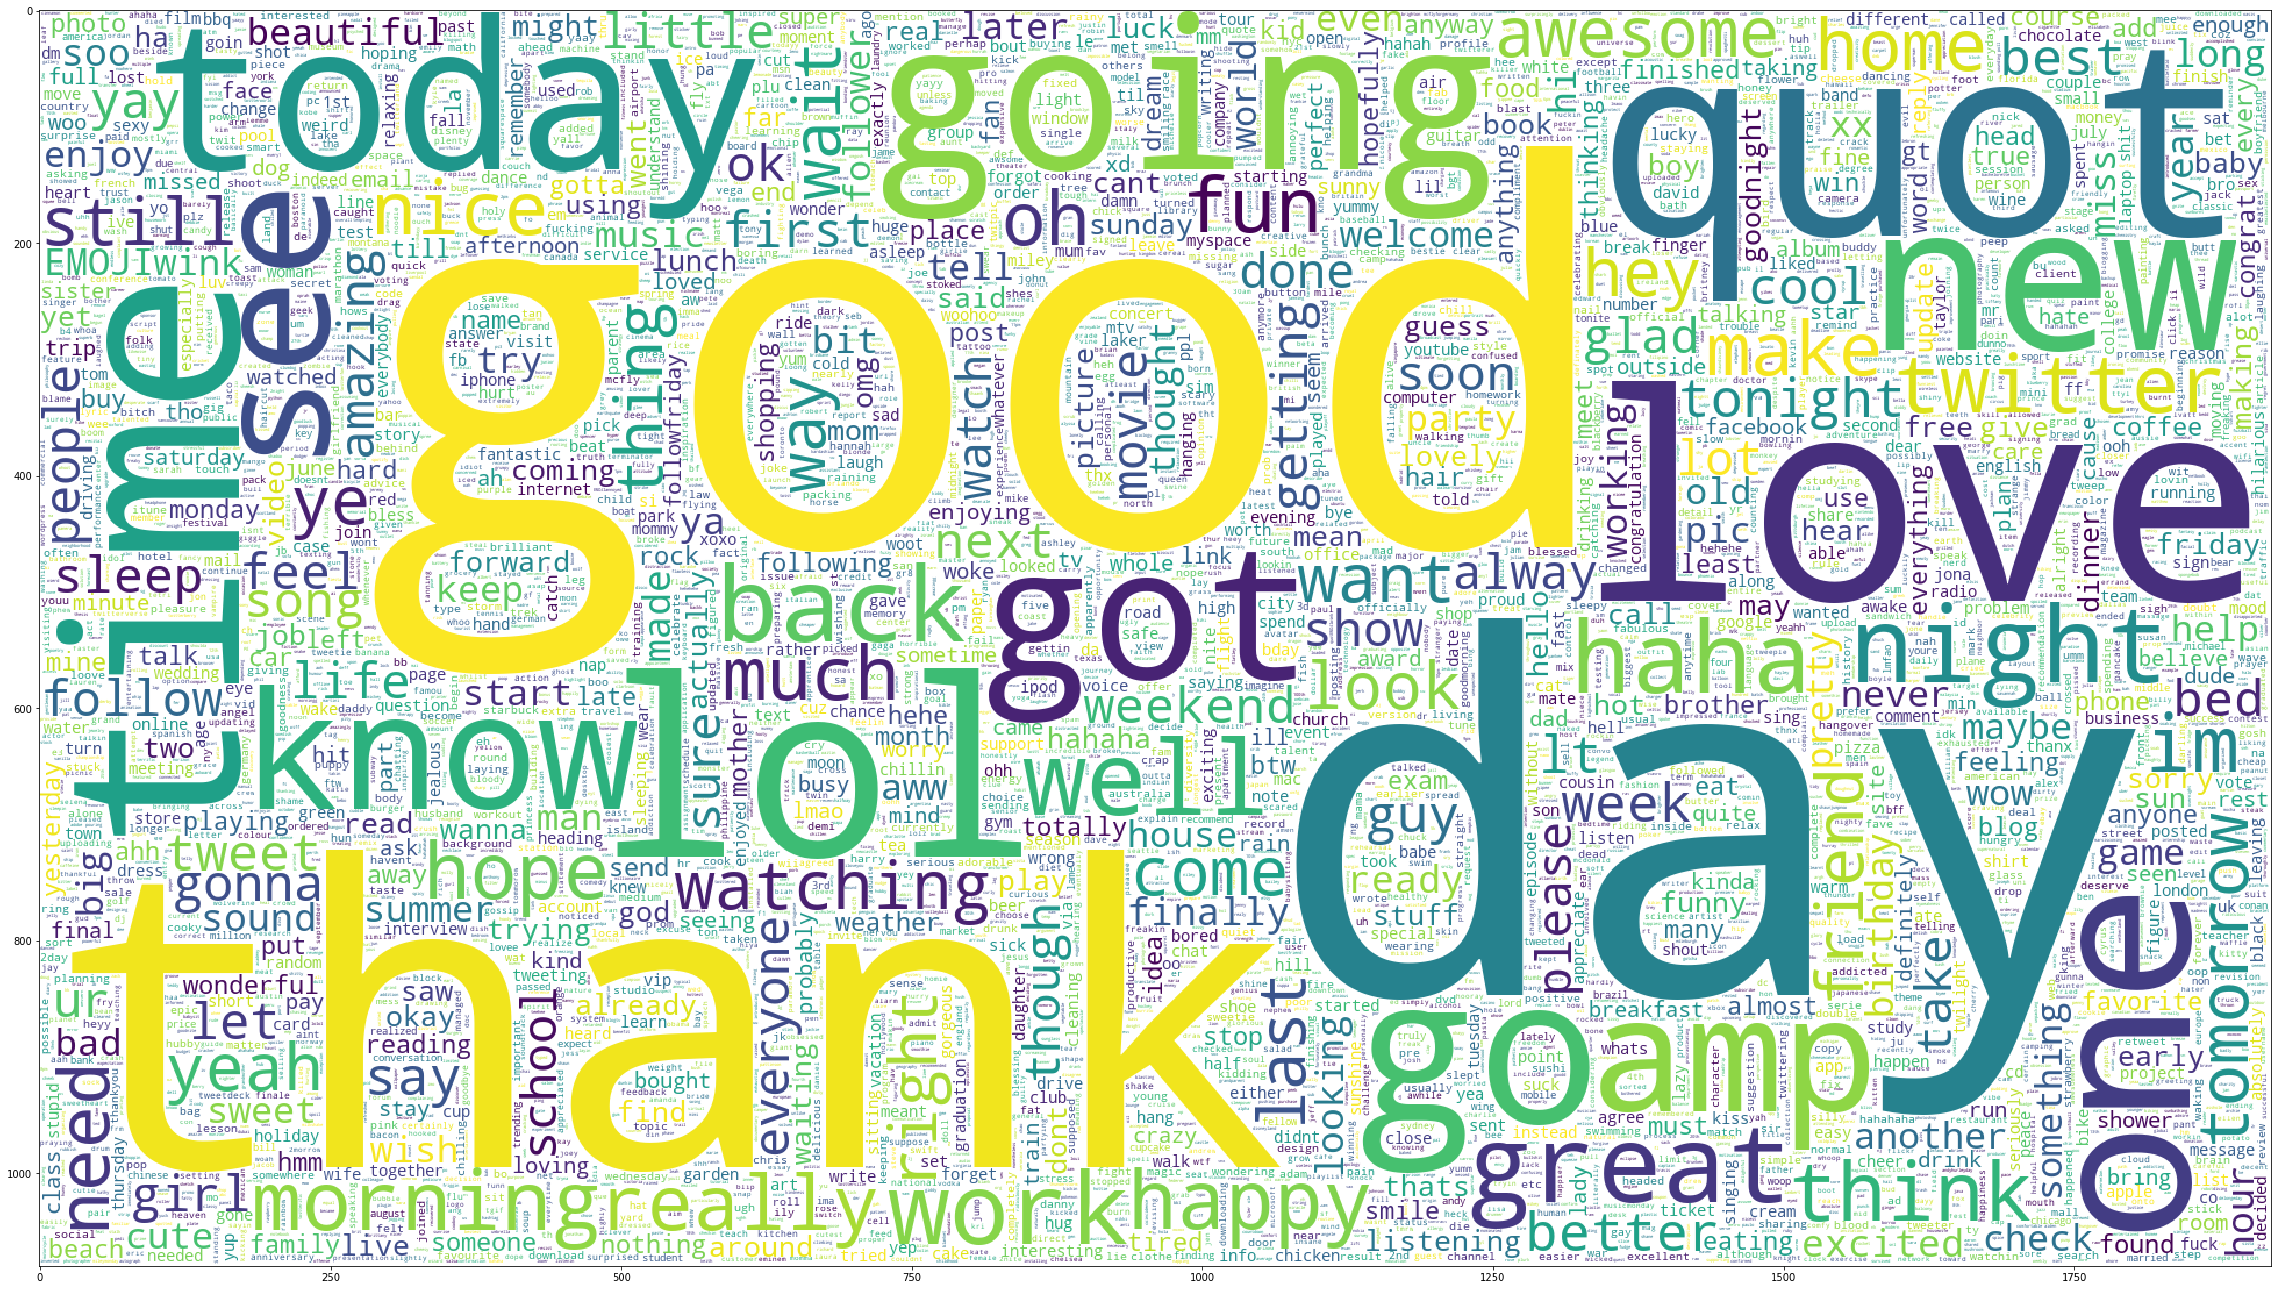

In [19]:
data_pos = processed_text[800000:]
wc = WordCloud(max_words = 300000,background_color ='white', width = 1920 , height = 1080,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (40,40))
plt.imshow(wc)

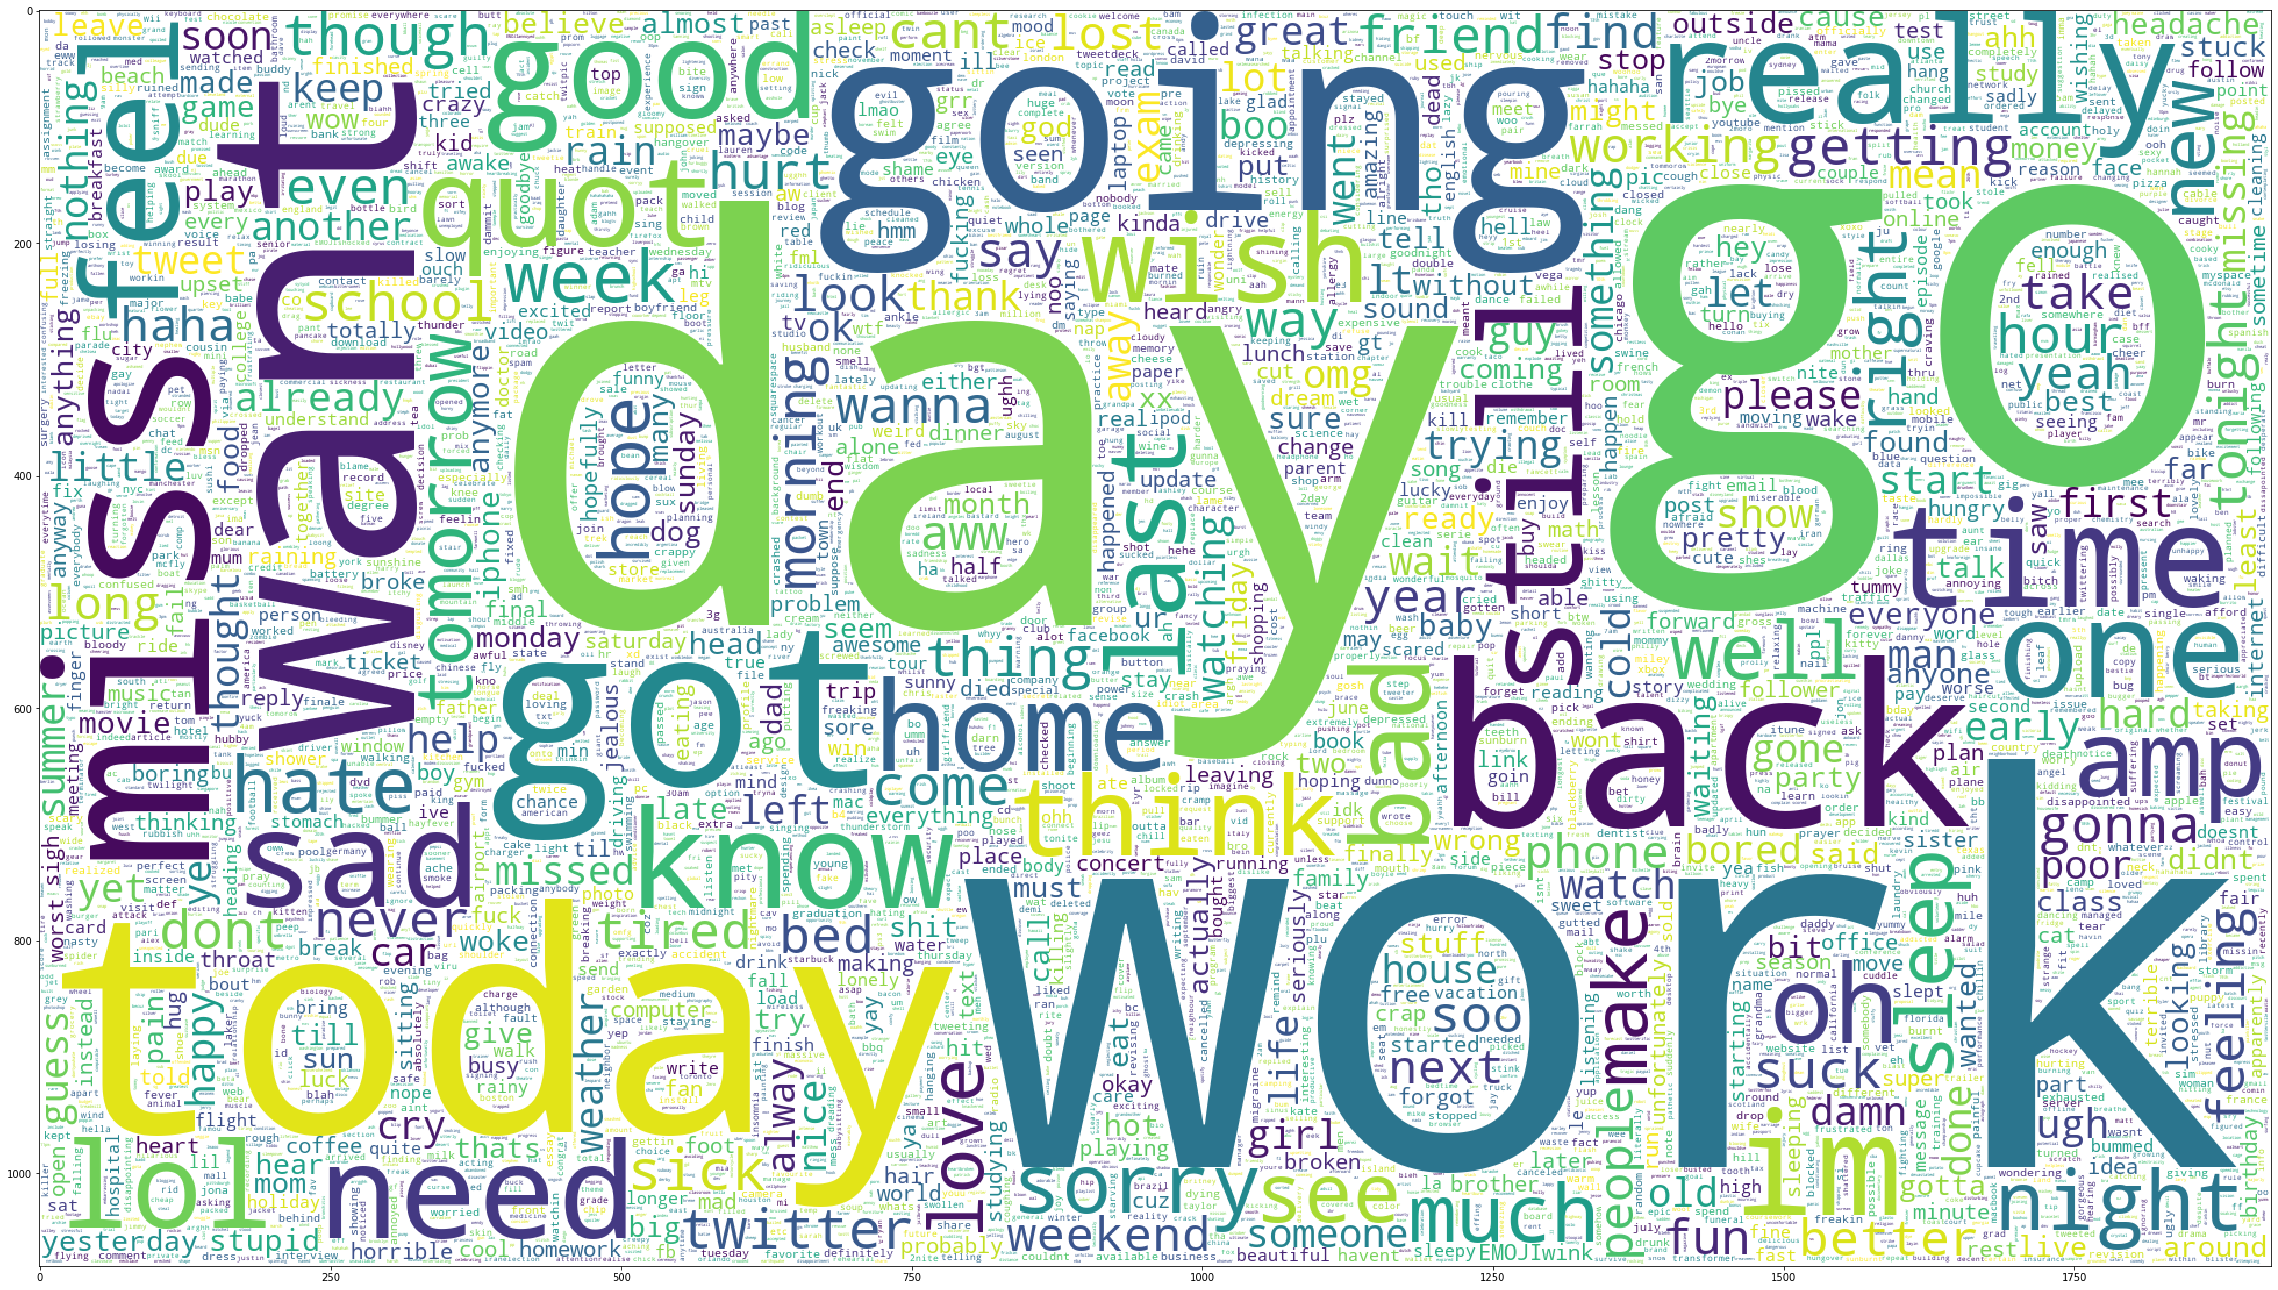

In [20]:
data_pos = processed_text[:800000]
wc = WordCloud(max_words = 300000,background_color ='white', width = 1920 , height = 1080,
              collocations=False).generate(" ".join(data_pos))
plt.figure(figsize = (40,40))
plt.imshow(wc)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(processed_text, sentiment, test_size = 0.05, random_state = 0)

### TfidfVectorizer

* The goal of using tf-idf is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

In [22]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features = 500000)
vectoriser.fit(X_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0,
                max_features=500000, min_df=1, ngram_range=(1, 2), norm='l2',
                preprocessor=None, smooth_idf=True, stop_words=None,
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [23]:
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)

#### A small function for easier and easier use of the model. It can make your work quite easy when using more than one model.

In [24]:
def model_evaluate(model):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    
    categories = ['Negative', 'Positive']
    group_names = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
    group_percentages = ['{0:.2%}'.format(value) for value in cm.flatten() / np.sum(cm)] 
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(cm, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
  

### Modelling

              precision    recall  f1-score   support

           0       0.81      0.78      0.79     39989
           1       0.79      0.81      0.80     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000

Logistic Regression complete.
Time Taken: 20 seconds


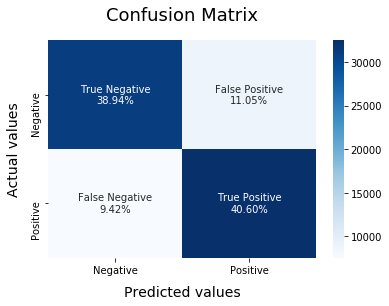

In [28]:
t = time.time()
model = LogisticRegression()
model.fit(X_train, y_train)
model_evaluate(model)
print(f'Logistic Regression complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

In [29]:
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('sentiment_logistic.pickle','wb')
pickle.dump(model, file)
file.close()

## Let's do a few tries.

In [45]:
if __name__=="__main__":
    
    def load_models():

        file = open('vectoriser-ngram-(1,2).pickle', 'rb')
        vectoriser = pickle.load(file)
        file.close()

        file = open('sentiment_logistic.pickle', 'rb')
        log_model = pickle.load(file)
        file.close()

        return vectoriser, log_model
    
    def predict(vectoriser, model, text):

        textdata = vectoriser.transform(preprocess(text))
        sentiment = model.predict(textdata)

        data = []
        for text, pred in zip(text, sentiment):
            data.append((text,pred))

        df = pd.DataFrame(data, columns = ['text','sentiment'])
        df = df.replace([0,1], ["Negative","Positive"])
        return df

    vectoriser, log_model = load_models()
    
    text = ["Data science is a very enjoyable job.",
            "Twitter is unnecessary.",
            "I dont feel good."]
    
    df = predict(vectoriser, log_model, text)
    print(df.head())

                                    text sentiment
0  Data science is a very enjoyable job.  Positive
1                Twitter is unnecessary.  Negative
2                      I dont feel good.  Negative
